## Setup

In [39]:
import ugradio
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.stats import norm, linregress
from scipy.optimize import curve_fit
from uncertainties import ufloat
from scipy.signal import find_peaks
import os
import glob
import time

In [40]:
# Consistent Plot Params
titleSize = 15
axisSize = 15
legendSize = 13
graphSizeSingle = (8, 6)
graphSizeDouble = (15, 6)

## Data Extraction

In [41]:
def extractRawData(folder, filename):
    prefix = "ugastro\\Lab3Data\\" + folder
    raw_data = np.load(prefix + filename, allow_pickle=True)
    return raw_data

def getDataBlocks(data, buffer=10, num_blocks=2030):
    new_data = np.zeros((num_blocks, 1024), dtype=complex)
    for i, block in enumerate(data[buffer:num_blocks+buffer]):
        new_data[i] = normalize(block['corr01'])
    return new_data

def getDataSingleBlock(data, block=1):
    real = data['time_data'][block][:, 0]
    imag = data['time_data'][block][:, 1]
    return normalize(real + (1j * imag))

def getHorizonRawData(folder, extension="npy"):
    # Load and merge many files
    directory = "ugastro\\Lab3Data\\" + folder
    file_paths = sorted(glob.glob(os.path.join(directory, f"*.{extension}")))
    if not file_paths:
        print("No files found. Check the directory path and file extension.")
        return None
    
    data = []
    for file in file_paths:
        try:
            data.append(np.load(file, allow_pickle=True))
        except Exception as e:
            print(f"Error loading {file}: {e}")

    if data:
        merged_data = np.concatenate(data, axis=0)
        return merged_data
    else:
        print("No valid data files loaded.")
        return None

def getSampleRate(data):
    return data['sample_rate']

def getGain(data):
    return data['gain']

def getUTC(data):
    return data['utc']

def getJulianDate(data):
    return data['jd']

def windowData(data):
    return data[:]

def normalize(data):
    return (data - np.mean(data)) #/ np.std(data)

def getTimesJD(data):
    times = [data[i]['time'] for i in range(len(data))]
    return times

def getTimesLocal(data):
    times = [data[i]['time'] for i in range(len(data))]
    adjusted = [time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime(time_i)) for time_i in times]
    return adjusted


In [42]:
# Week 1
folder = "Week1_Testing\\"
data_test_raw = extractRawData(folder, "test_observatin_data.npy")
data_test = getDataBlocks(data_test_raw)
data_test_2_raw = extractRawData(folder, "Mar12_test_observation_data.npz")
data_test_2 = getDataBlocks(data_test_2_raw['arr_0'])

data_horizon_raw_1 = extractRawData(folder, "Mar13_12hour_observation_data.npz")
data_horizon_1 = getDataBlocks(data_horizon_raw_1['arr_0'], )

data_horizon_raw_2 = getHorizonRawData("Mar15_Observation")
data_horizon_2 = normalize(getDataBlocks(data_horizon_raw_2, buffer=10, num_blocks=28700))

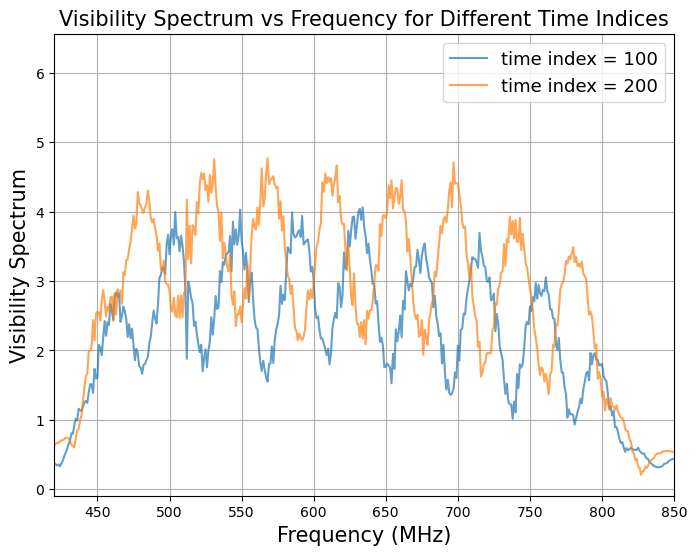

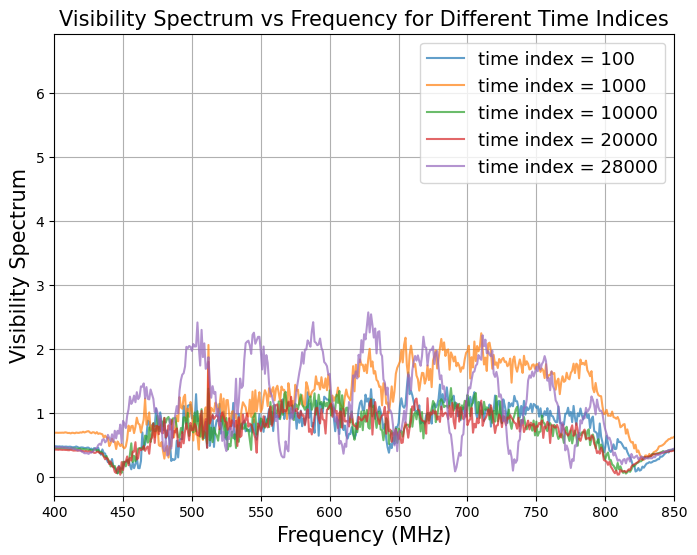

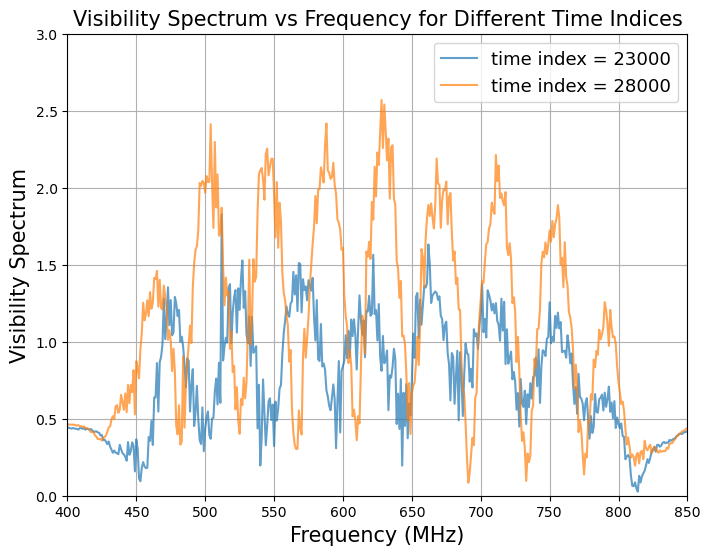

In [90]:
def plot_power_spectrum(data, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    freqs = np.linspace(0, 500, len(data[0]))

    for index in indices:
        spectrum = np.abs(data[index])
        plt.plot(spectrum, label=f"time index = {index}", alpha=0.7)
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Visibility Spectrum", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Visibility Spectrum vs Frequency for Different Time Indices", size=titleSize)
    plt.grid()
    plt.show()

plot_power_spectrum(data_test, indices=[100, 200], xlim=(420, 850))
#plot_power_spectrum(data_test_2, indices=[100, 200, 500, 1000], xlim=(150, 450), ylim=(0, 2))
#plot_power_spectrum(data_horizon_1, indices=[100, 200, 500, 1000], xlim=(150, 450), ylim=(0, 2))
plot_power_spectrum(data_horizon_2, indices=[100, 1000, 10000, 20000, 28000], xlim=(400, 850))
plot_power_spectrum(data_horizon_2, indices=[23000, 28000], xlim=(400, 850), ylim=(0, 3))

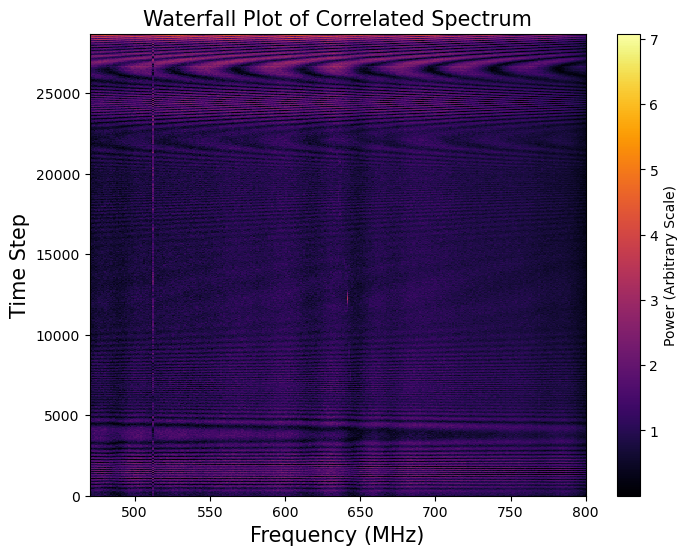

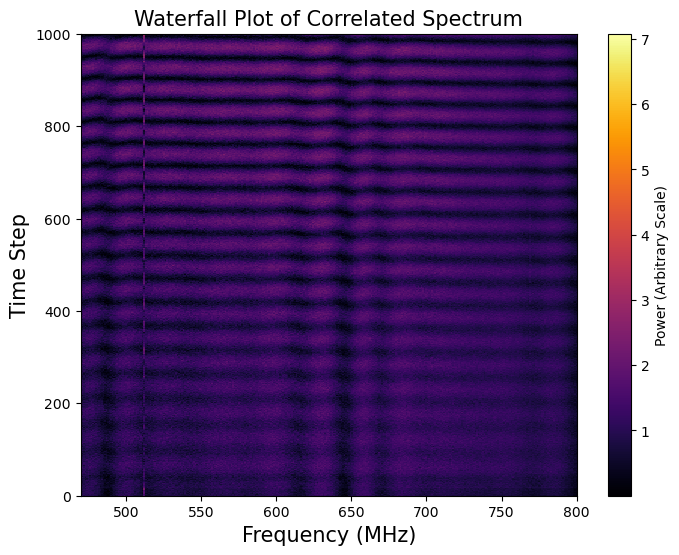

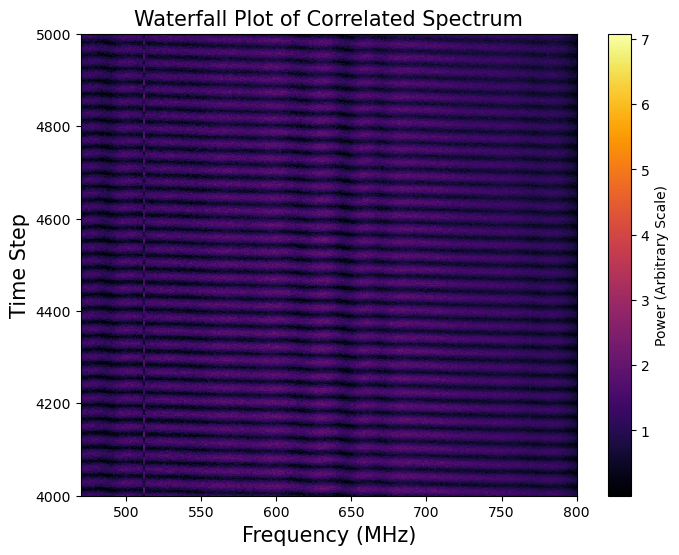

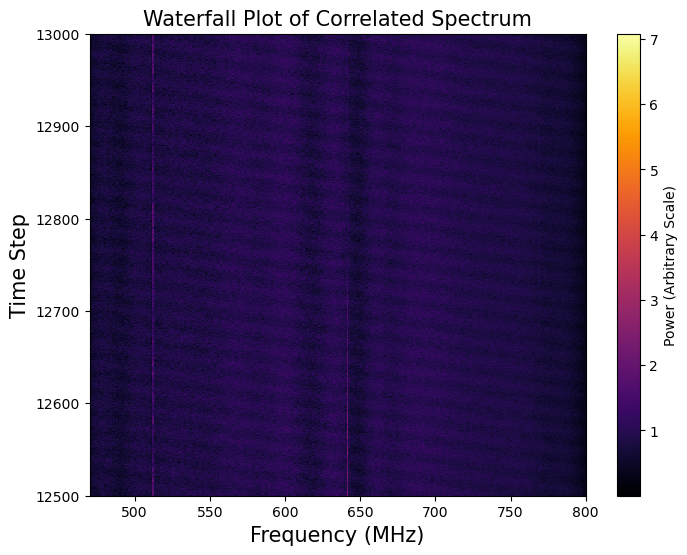

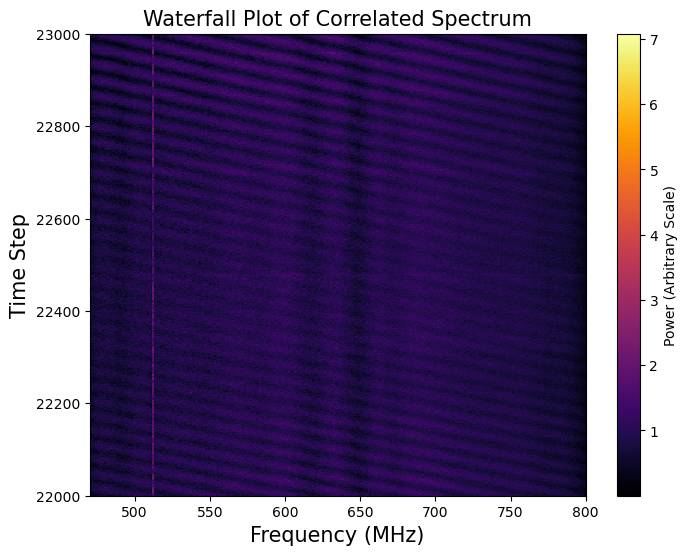

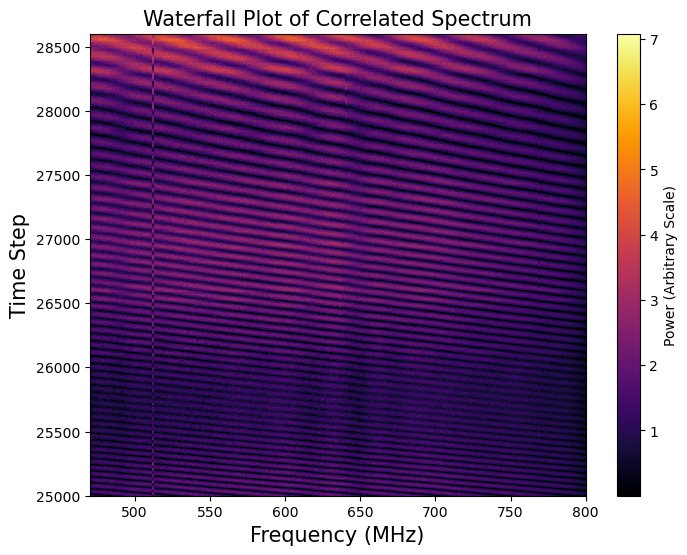

In [44]:
def plot_waterfall(data, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    plt.imshow(np.abs(data), aspect='auto', cmap='inferno', norm='linear',
                interpolation='nearest', origin='lower')
    plt.colorbar(label="Power (Arbitrary Scale)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum", size=titleSize)
    plt.show()

def plot_waterfall_corr(data, baseline, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    plt.imshow(np.abs(data) - np.abs(baseline), aspect='auto', cmap='inferno', norm='linear',
               interpolation='nearest', origin='lower')
    plt.colorbar(label="Power (Arbitrary Scale)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum", size=titleSize)
    plt.show()

#plot_waterfall(data_test)
#plot_waterfall(data_test_2)
#plot_waterfall_corr(data_test[:400], data_test_2[:400], xlim=(220, 400))
plot_waterfall(data_horizon_2, xlim=(470, 800))
plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(0, 1000))
plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(4000, 5000))
plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(12500, 13000))
plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(22000, 23000))
plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(25000, 28600))

In [45]:
print("First time step max power:", np.max(np.abs(data_test[0])))
print("Middle time step max power:", np.max(np.abs(data_test[1000])))
print("Last time step max power:", np.max(np.abs(data_test[2000])))

First time step max power: 6.479164848331056
Middle time step max power: 5.474793418763554
Last time step max power: 6.287294479134265


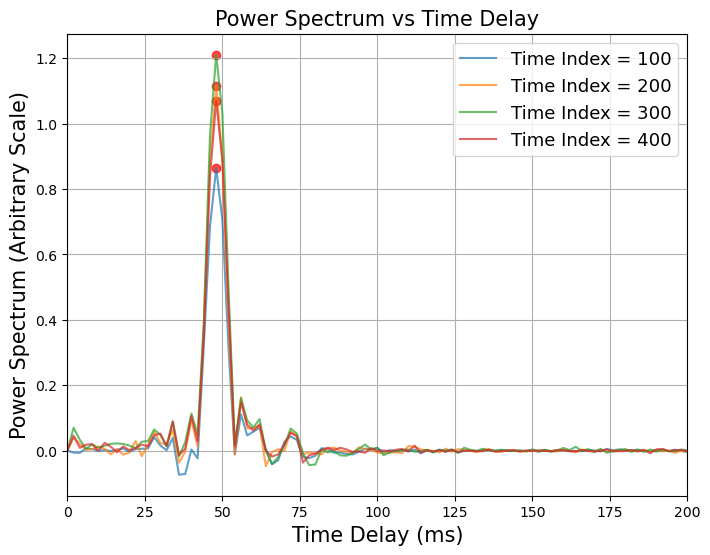

Peaks = 24
Amplitudes = 1.07


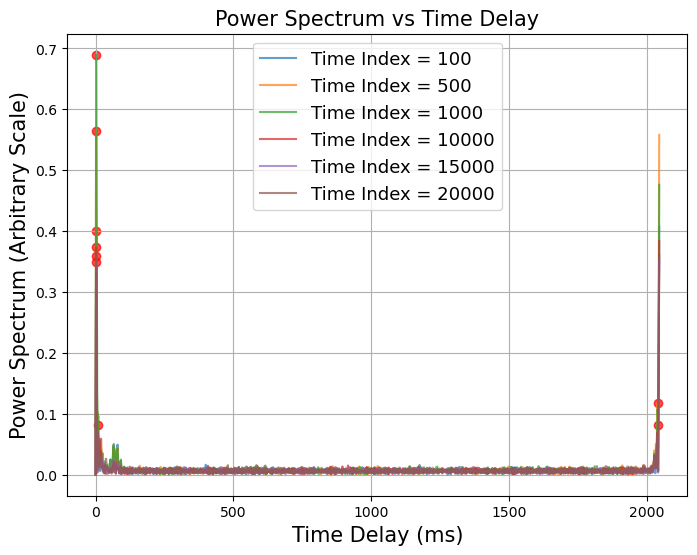

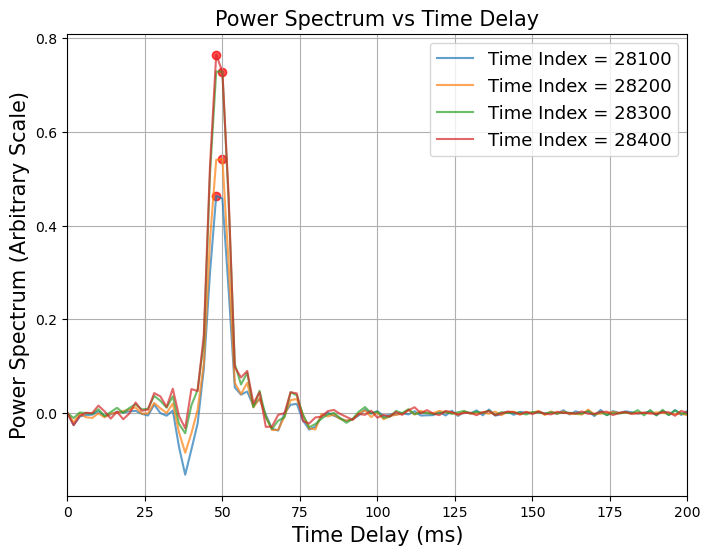

(array([24], dtype=int64), {'peak_heights': array([0.76440942])})

In [46]:
def plot_time_delay(data, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [2*i for i in range(len(data[0]))] # 2ms per sample

    for index in indices:
        time_signal = np.abs(ifft(data[index]))
        amplitude = np.abs(time_signal)
        threshold = 0.2 * np.max(amplitude)
        peaks, properties = find_peaks(amplitude, height=threshold)
        if index == 0:
            print(f"Peak = {peaks}")

        plt.plot(times, amplitude, label=f"Time Index = {index}", alpha=0.7)
        plt.scatter(peaks*2, amplitude[peaks], color='r', marker='o', alpha=0.7)
    plt.xlabel("Time Delay (ms)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Power Spectrum vs Time Delay", size=titleSize)
    plt.grid()
    plt.show()
    return peaks, properties

def plot_time_delay_corr(data, baseline, indices=[100], offset=0, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [2*i for i in range(len(data[0]))] # 2ms per sample

    for index in indices:
        time_signal = np.abs(ifft(data[index]))
        time_signal_baseline = np.abs(ifft(baseline[index]))
        amplitude = np.abs(time_signal)
        amplitude_baseline = np.abs(time_signal_baseline)
        amplitude -= amplitude_baseline
        threshold = 0.2 * np.max(amplitude)
        peaks, properties = find_peaks(amplitude, height=threshold)

        plt.plot(times, amplitude, label=f"Time Index = {offset+index}", alpha=0.7)
        plt.scatter(peaks*2, amplitude[peaks], color='r', marker='o', alpha=0.7)
    plt.xlabel("Time Delay (ms)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Power Spectrum vs Time Delay", size=titleSize)
    plt.grid()
    plt.show()
    return peaks, properties

#plot_time_delay(data_test, indices=[100, 200, 300, 400, 500], xlim=(0, 200))
#plot_time_delay(data_test_2, indices=[100, 200, 300, 400, 500], xlim=(0, 200))
peaks, amps = plot_time_delay_corr(data_test[:450], data_test_2[:450], indices=[100, 200, 300, 400], xlim=(0, 200))
print(f"Peaks = {peaks[0]}")
print(f"Amplitudes = {np.round(amps['peak_heights'][0], 3)}")

plot_time_delay(data_horizon_2, indices=[100, 500, 1000, 10000, 15000, 20000])
plot_time_delay_corr(data_horizon_2[28000:28450], data_test_2[:450], indices=[100, 200, 300, 400], offset=28000, xlim=(0, 200))

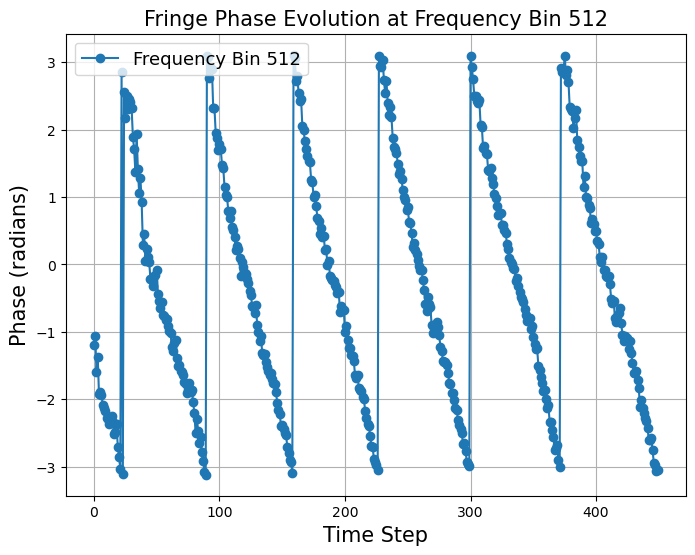

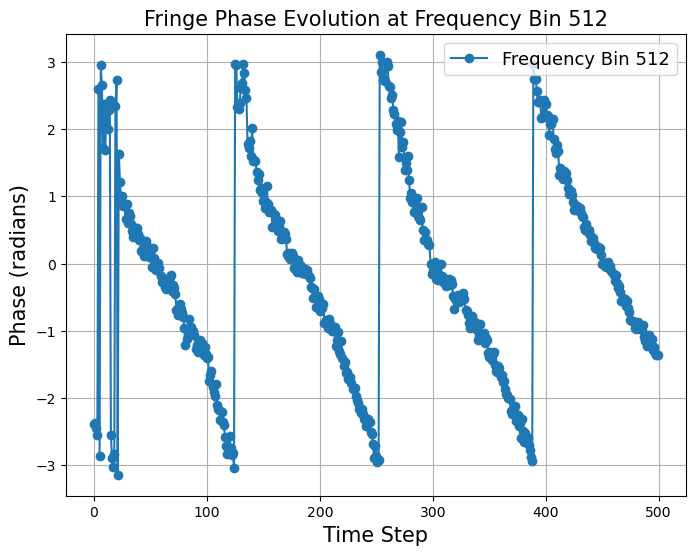

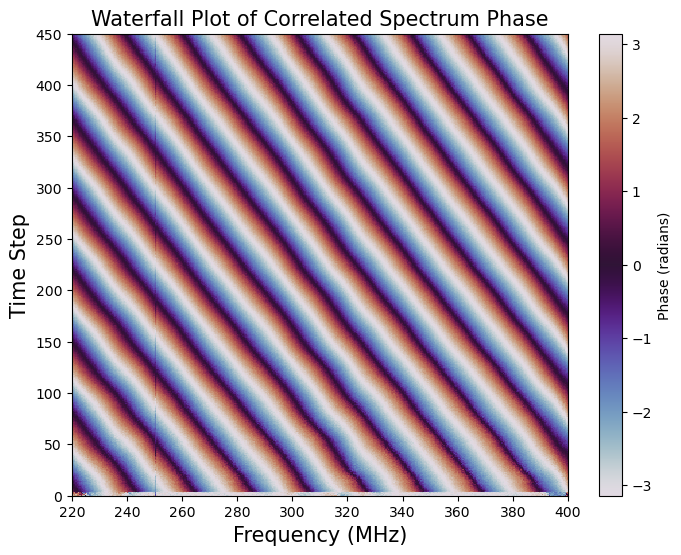

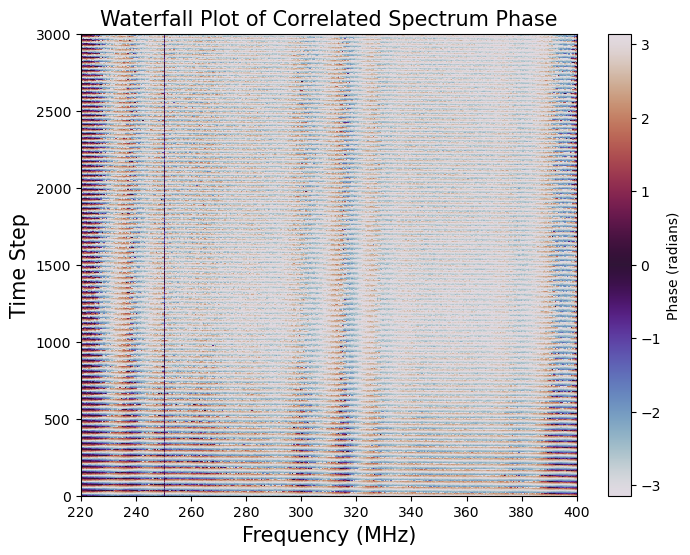

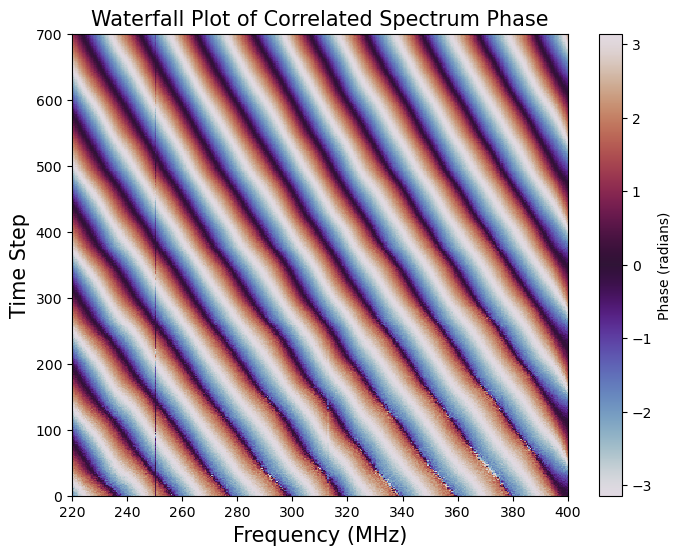

In [47]:
def plot_phase_evolution(data, freq_bin=512):
    time_steps = np.arange(data.shape[0])
    phases = np.angle(data[:, freq_bin])  # Extract column (frequency bin) and compute phase

    plt.figure(figsize=graphSizeSingle)
    plt.plot(time_steps, phases, marker='o', linestyle='-', label=f"Frequency Bin {freq_bin}")
    plt.xlabel("Time Step", fontsize=axisSize)
    plt.ylabel("Phase (radians)", fontsize=axisSize)
    plt.title(f"Fringe Phase Evolution at Frequency Bin {freq_bin}", size=titleSize)
    plt.legend(fontsize=legendSize)
    plt.grid()
    plt.show()

def plot_phase_waterfall(data, freq_bin=512, xlim=None, ylim=None):
    phases = np.angle(data)

    plt.figure(figsize=graphSizeSingle)
    plt.imshow(phases, aspect='auto', cmap='twilight', norm='linear',
               extent=[0, 500, 0, data.shape[0]], interpolation='nearest',
               origin='lower')
    plt.colorbar(label="Phase (radians)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum Phase", size=titleSize)
    plt.show()


plot_phase_evolution(data_test[:450], freq_bin=512)
plot_phase_evolution(data_horizon_2[28200:], freq_bin=512)
plot_phase_waterfall(data_test[:450], xlim=(220, 400))
plot_phase_waterfall(data_horizon_2[2000:5000], xlim=(220, 400))
plot_phase_waterfall(data_horizon_2[28000:], xlim=(220, 400))

In [48]:
def compute_delta(jd_start, jd_end, num_time_steps):
    jds = np.linspace(jd_start, jd_end, num_time_steps)
    return [np.radians(ugradio.coord.sunpos(jds[i])[1]) for i in range(num_time_steps)]

def tau_g(h_s, b_ew, b_ns, delta, L, c=3e8):
    left_part = ((b_ew / c) * np.cos(delta)) * np.cos(h_s)
    right_part = (b_ns / c) * np.cos(L) * np.sin(delta)
    return left_part - right_part

def fringe_model(hs, A, B, freq, b_ew, b_ns, delta, L):
    # Eventually solving for A & B
    tau_g_vals = tau_g(hs, b_ew, b_ns, delta, L)
    left_part = A * np.cos(2 * np.pi * freq * tau_g_vals)
    right_part = B * np.sin(2 * np.pi * freq * tau_g_vals)
    return left_part + right_part

def compute_local_fringe_freq(data):
    time_steps = np.arange(data.shape[0])
    phase = np.unwrap(np.angle(data))
    fringe_freq = np.gradient(phase, time_steps) / (2 * np.pi)

    plt.figure(figsize=graphSizeSingle)
    plt.plot(time_steps, fringe_freq, label="Local Fringe Frequency", color='r')
    plt.xlabel('Time Steps', fontsize=axisSize)
    plt.ylabel('Frequency (Hz)', fontsize=axisSize)
    plt.title('Computed Local Fringe Frequency', size=titleSize)
    plt.legend(fontsize=legendSize)
    plt.grid()
    plt.show

    return fringe_freq

def fit_least_squares(data, b_ew, b_ns, delta, L, xlim=None, ylim=None):
    time_steps = np.arange(data.shape[0])
    fringe = np.abs(data)

    tau_g_vals = tau_g(time_steps, b_ew, b_ns, delta, L)
    fringe_freq = compute_local_fringe_freq(data)

    # Design matrix
    X = np.column_stack([np.cos(2 * np.pi * tau_g_vals), np.sin(2 * np.pi * tau_g_vals)])
    beta, residuals, _, _ = np.linalg.lstsq(X, fringe, rcond=None)
    A, B = beta

    fringe_amplitude = np.sqrt(A**2 + B**2)
    fitted_phase = np.arctan2(B, A)

    plt.figure(figsize=graphSizeSingle)
    plt.plot(time_steps, fringe, label="Measured Fringe")
    plt.plot(time_steps, fringe_model(time_steps, A, B, fringe_freq, b_ew, b_ns, delta, L), 
            label="Fitted Fringe", linestyle='dashed')

    plt.xlabel("Time Step", fontsize=axisSize)
    plt.ylabel("Fringe Amplitude (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Least Squares Fitting of Fringe Amplitude", size=titleSize)
    plt.grid()
    plt.show()

    return fringe_amplitude, fitted_phase, beta, residuals

b_ew = 20
b_ns = 0
#jd_start, jd_end = 
#delta = compute_delta(jd_start, jd_end, len(data_test[:450]))
#L = np.radians() # lattitude


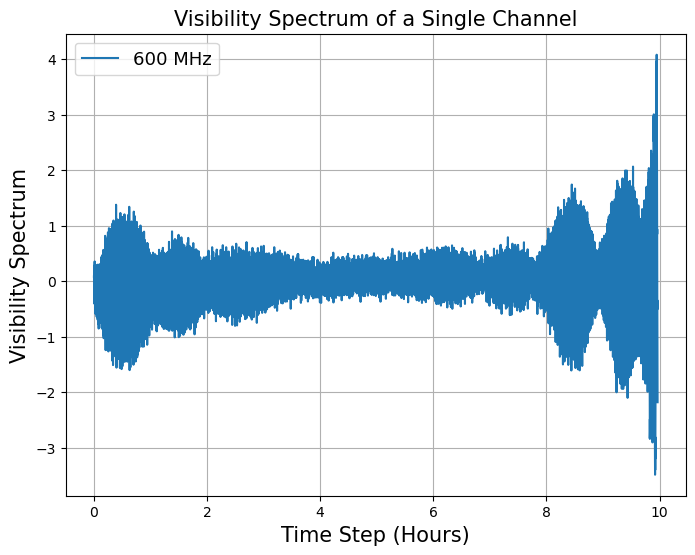

1742052738.9676688
Mar 15, 8:32:19 AM
1742088640.6338058
Mar 15, 6:30:41 PM
Difference of 9hr, 58 mins, 22 sec
28720
1.25 seconds per time step


In [85]:
def graphSingleChannelOverTime(data, channel=600, xlim=None, ylim=None):
    # 450 < channel < 800
    plt.figure(figsize=graphSizeSingle)
    channel_data = normalize(data[:, channel])
    #times = np.linspace(0, len(channel_data)*1.25, len(channel_data))
    times = [(x*1.25)/3600 for x in range(len(data))]

    plt.plot(times, channel_data, label=f"{channel} MHz")
    plt.xlabel("Time Step (Hours)", fontsize=axisSize)
    plt.ylabel("Visibility Spectrum", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Visibility Spectrum of a Single Channel", size=titleSize)
    plt.grid()
    plt.show()

graphSingleChannelOverTime(data_horizon_2, channel=600)
time_data = getTimesJD(data_horizon_raw_2)
print(time_data[0])
print("Mar 15, 8:32:19 AM")
print(time_data[-1])
print("Mar 15, 6:30:41 PM")
print("Difference of 9hr, 58 mins, 22 sec")
print(len(time_data))
print("1.25 seconds per time step")

NOTES: 

dont do absolute value, keep real and complex data and find way to fix systematics (misalignment)?

waterfall plot for angle flip axes

non perfect bessel func bc not perfect disk (sun spot delta -> (FFT) -> flat function / baseline instead of 0)